In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Dropout, LayerNormalization, Attention, Lambda, Concatenate, MultiHeadAttention, GlobalAveragePooling1D
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input
from torch.utils.data import DataLoader, TensorDataset


In [38]:
dataset = pd.read_csv('/content/updated_dataset1.csv')

# Taking first 1000 rows
# dataset = dataset.head(10000)

dataset.head()

,Year,MonthOfYear,DayOfYear,TimeOfDay(Hour),Temperature,ClearskyDNI,CloudType,DewPoint,Radiation(DNI),DiffuseHorizontalIrradiance(DHI),GlobalHorizontalIrradiance(GHI),RelativeHumidity,SolarZenithAngle,SurfaceAlbedo,Pressure,WindSpeed,WindDirection,load_demand_kW,ev_demand_kW
0,2019,1,1,0,7.6,0,1,6.7,0,0,0,94.23,95.11,0.13,961,0.5,35,340.03,6.78
1,2019,1,1,1,10.7,490,0,6.9,490,35,97,77.31,82.73,0.13,962,0.0,9,378.85,0.00
2,2019,1,1,2,14.8,760,0,6.6,760,61,303,57.77,71.37,0.13,963,0.0,6,365.20,0.00
3,2019,1,1,3,19.6,882,0,6.2,882,72,496,41.71,61.27,0.13,963,0.0,48,322.39,0.00
4,2019,1,1,4,23.1,937,0,5.1,937,80,640,31.04,53.25,0.13,962,0.0,45,370.43,10.89


In [39]:
dataset.columns

Index(['Year', 'MonthOfYear', 'DayOfYear', 'TimeOfDay(Hour)', 'Temperature',
       'ClearskyDNI', 'CloudType', 'DewPoint', 'Radiation(DNI)',
       'DiffuseHorizontalIrradiance(DHI)', 'GlobalHorizontalIrradiance(GHI)',
       'RelativeHumidity', 'SolarZenithAngle', 'SurfaceAlbedo', 'Pressure',
       'WindSpeed', 'WindDirection', 'load_demand_kW', 'ev_demand_kW'],
      dtype='object')

In [40]:

dataset.shape

(8760, 19)

In [41]:
dataset.describe()

,Year,MonthOfYear,DayOfYear,TimeOfDay(Hour),Temperature,ClearskyDNI,CloudType,DewPoint,Radiation(DNI),DiffuseHorizontalIrradiance(DHI),GlobalHorizontalIrradiance(GHI),RelativeHumidity,SolarZenithAngle,SurfaceAlbedo,Pressure,WindSpeed,WindDirection,load_demand_kW,ev_demand_kW
count,8760.0,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.00000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,2019.0,6.526027,15.720548,11.500000,24.815868,309.810502,2.82968,17.125514,192.384132,91.693607,265.442237,67.655394,89.748199,0.135945,951.165183,0.158368,167.352169,391.210372,21.593597
std,0.0,3.448048,8.796749,6.922582,6.491817,355.289767,3.06805,6.090672,291.540540,132.787844,338.680135,24.432548,43.274836,0.008759,5.102824,0.258105,99.527470,84.501389,26.605589
min,2019.0,1.000000,1.000000,0.000000,7.000000,0.000000,0.00000,0.600000,0.000000,0.000000,0.000000,13.690000,4.510000,0.110000,937.000000,0.000000,0.000000,257.160000,0.000000
25%,2019.0,4.000000,8.000000,5.750000,21.000000,0.000000,0.00000,11.700000,0.000000,0.000000,0.000000,47.757500,52.140000,0.130000,947.000000,0.000000,75.000000,334.487500,4.000000
50%,2019.0,7.000000,16.000000,11.500000,24.900000,0.000000,1.00000,18.600000,0.000000,0.000000,0.000000,69.280000,89.555000,0.140000,952.000000,0.000000,177.000000,366.115000,9.595000
75%,2019.0,10.000000,23.000000,17.250000,29.200000,690.000000,7.00000,22.600000,346.250000,140.000000,571.000000,90.192500,127.160000,0.140000,955.000000,0.300000,245.000000,413.725000,33.277500
max,2019.0,12.000000,31.000000,23.000000,40.600000,978.000000,9.00000,27.500000,978.000000,515.000000,1007.000000,100.000000,175.690000,0.160000,966.000000,1.100000,360.000000,722.170000,175.700000


In [42]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 19 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Year                              8760 non-null   int64  
 1   MonthOfYear                       8760 non-null   int64  
 2   DayOfYear                         8760 non-null   int64  
 3   TimeOfDay(Hour)                   8760 non-null   int64  
 4   Temperature                       8760 non-null   float64
 5   ClearskyDNI                       8760 non-null   int64  
 6   CloudType                         8760 non-null   int64  
 7   DewPoint                          8760 non-null   float64
 8   Radiation(DNI)                    8760 non-null   int64  
 9   DiffuseHorizontalIrradiance(DHI)  8760 non-null   int64  
 10  GlobalHorizontalIrradiance(GHI)   8760 non-null   int64  
 11  RelativeHumidity                  8760 non-null   float64
 12  SolarZ

In [43]:
dataset.isnull().sum()

,0
Year,0
MonthOfYear,0
DayOfYear,0
TimeOfDay(Hour),0
Temperature,0
ClearskyDNI,0
CloudType,0
DewPoint,0
Radiation(DNI),0
DiffuseHorizontalIrradiance(DHI),0


Let's have a look at our target column

In [44]:
dataset['Radiation(DNI)'].describe()

,Radiation(DNI)
count,8760.000000
mean,192.384132
std,291.540540
min,0.000000
25%,0.000000
50%,0.000000
75%,346.250000
max,978.000000


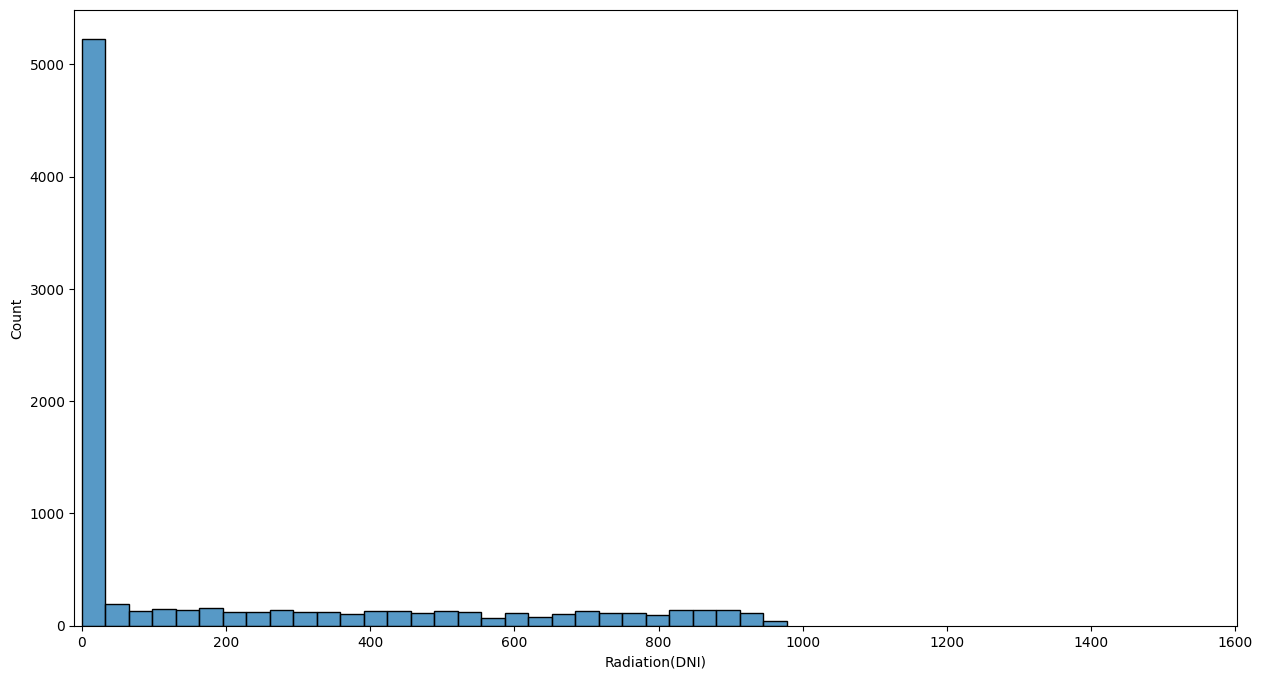

In [45]:

# Create figure and axes
f, ax = plt.subplots(figsize=(15, 8))

sns.histplot(data=dataset['Radiation(DNI)'], ax=ax)
# sns.histplot(data=dataset['Radiation(DNI)'], ax=ax, kde=True)

# Set x-axis limits
plt.xlim([-10, 1602])

# Optional: Show the plot
plt.show()

Feature Engineering

In [46]:
# dataset['Pressure'] = dataset['Pressure'] / 1000
# dataset.head()
dataset = dataset.drop(['Year'], inplace=False, axis=1)

Feature Visualization

Text(0.5, 1.0, 'WindSpeed')

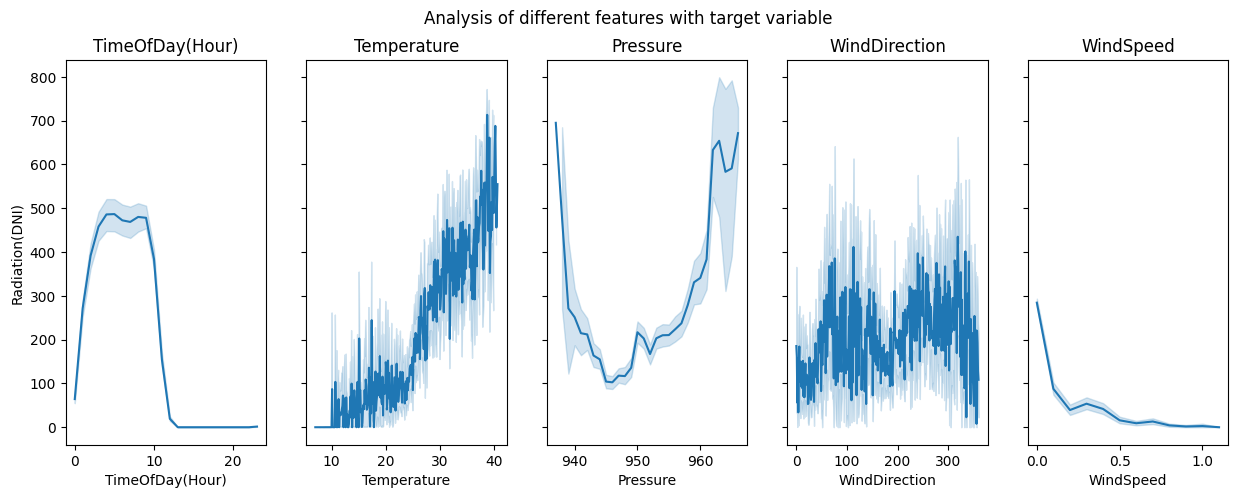

In [47]:

fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
fig.suptitle('Analysis of different features with target variable')

sns.lineplot(ax=axes[0], x=dataset['TimeOfDay(Hour)'].values, y=dataset['Radiation(DNI)'].values)
axes[0].set(xlabel='TimeOfDay(Hour)', ylabel = 'Radiation(DNI)')
axes[0].set_title(dataset['TimeOfDay(Hour)'].name)

sns.lineplot(ax=axes[1], x=dataset['Temperature'].values, y=dataset['Radiation(DNI)'].values)
axes[1].set(xlabel='Temperature', ylabel = 'Radiation(DNI)')
axes[1].set_title(dataset['Temperature'].name)

sns.lineplot(ax=axes[2],  x=dataset['Pressure'].values, y=dataset['Radiation(DNI)'].values)
axes[2].set(xlabel='Pressure', ylabel = 'Radiation(DNI)')
axes[2].set_title(dataset['Pressure'].name)

sns.lineplot(ax=axes[3],  x=dataset['WindDirection'].values, y=dataset['Radiation(DNI)'].values)
axes[3].set(xlabel='WindDirection', ylabel = 'Radiation(DNI)')
axes[3].set_title(dataset['WindDirection'].name)

sns.lineplot(ax=axes[4],  x=dataset['WindSpeed'].values, y=dataset['Radiation(DNI)'].values)
axes[4].set(xlabel='WindSpeed', ylabel = 'Radiation(DNI)')
axes[4].set_title(dataset['WindSpeed'].name)

Pearson Correlation

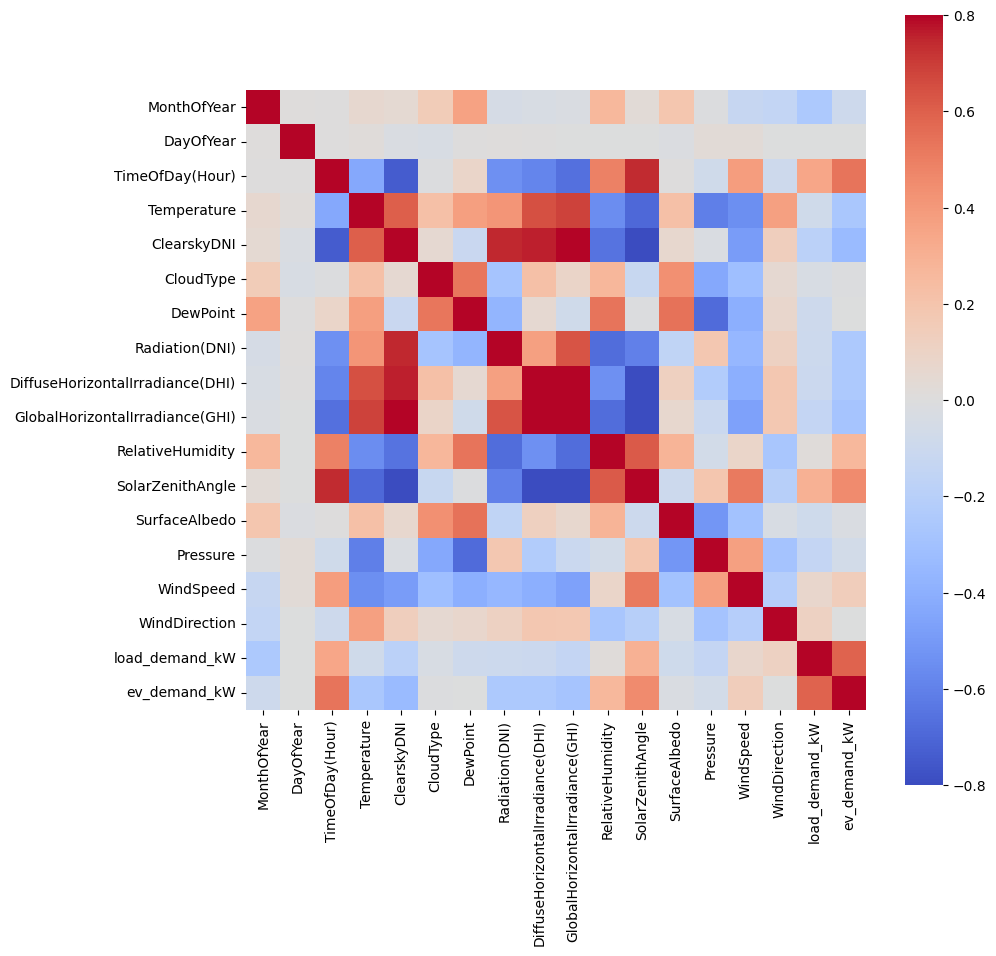

In [48]:
dataset.head()
# corrmat = dataset.drop(['MonthOfYear'], inplace=False, axis=1)
corrmat = dataset.corr()
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrmat, vmin=-.8, vmax=.8, square=True, cmap = 'coolwarm')
plt.show()

Separating the Independent and Dependent Variables

In [49]:
features = ['MonthOfYear', 'DayOfYear', 'TimeOfDay(Hour)', 'Temperature', 'ClearskyDNI',
            'CloudType', 'DewPoint', 'DiffuseHorizontalIrradiance(DHI)',
            'GlobalHorizontalIrradiance(GHI)', 'RelativeHumidity', 'SolarZenithAngle']
target = 'Radiation(DNI)'

In [50]:
# Normalize features
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [51]:
X_scaled = scaler_x.fit_transform(dataset[features])
y = dataset[target].values.reshape(-1, 1)
y_scaled = scaler_y.fit_transform(y)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 24, 64)         │        14,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,225 (94.63 KB)

 Trainable params: 24,225 (94.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 12s 33ms/step - loss: 0.0681 - val_loss: 0.0331
Epoch 2/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - loss: 0.0276 - val_loss: 0.0307
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 0.0242 - val_loss: 0.0289
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0201 - val_loss: 0.0327
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0185 - val_loss: 0.0280
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0188 - val_loss: 0.0269
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0171 - val_loss: 0.0260
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.0185 - val_loss: 0.0318
Epoch 9/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0167 - val_loss: 0.0316
Epoch 10/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - loss: 0.0180 - val_loss: 0.0318
Epoch 11/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0179 - val_loss: 0.0257
Epoch 12/20
197/197 ━━━━━━━━━━━━━━━━━━

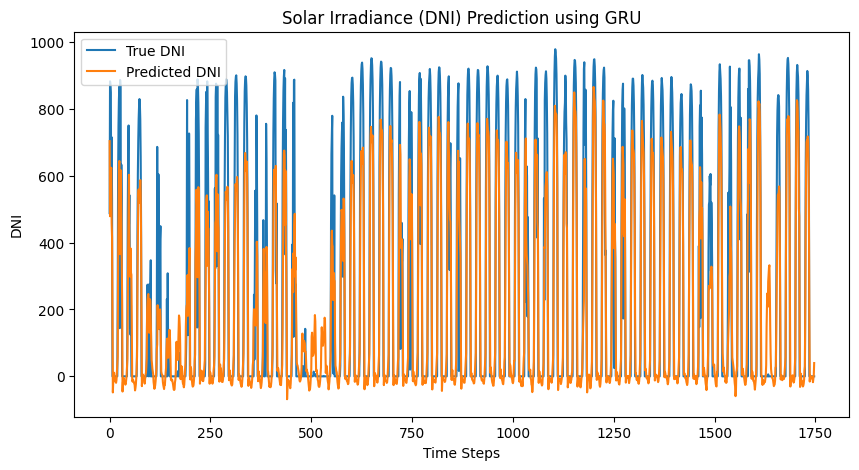

In [52]:
# Convert to sequences for GRU input
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps][0])
    return np.array(Xs), np.array(ys)

time_steps = 24  # 1 day if hourly data
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Build GRU model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)

# Predict and inverse transform
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='True DNI')
plt.plot(y_pred, label='Predicted DNI')
plt.title('Solar Irradiance (DNI) Prediction using GRU')
plt.xlabel('Time Steps')
plt.ylabel('DNI')
plt.legend()
plt.show()

In [53]:
# Evaluation metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mse)

# Print results
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R² Score: {r2:.3f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3f}")

Mean Squared Error (MSE): 21221.999
Mean Absolute Error (MAE): 94.622
R² Score: 0.830
Root Mean Squared Error (RMSE): 145.678


Attention Mechanism with GRU

In [54]:
!rm torch.py
!rm -rf __pycache__/

rm: cannot remove 'torch.py': No such file or directory


In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import math

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# New: Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, time_steps, d_model)
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

# New: Custom Scaled Dot-Product Attention class
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, dropout=0.1):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        # q, k, v: (batch_size, time_steps, d_k)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)  # (batch, time_steps, time_steps)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        output = torch.matmul(attn, v)  # (batch, time_steps, d_k)
        return output, attn

class GRUAttentionRegressor(nn.Module):
    def __init__(self, input_size, gru_hidden_size=64, attention_heads=4, attention_dim=32, dense_units=64):
        super(GRUAttentionRegressor, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=gru_hidden_size, batch_first=True)
        self.ln_gru = nn.LayerNorm(gru_hidden_size)

        # Modified: Add positional encoding
        self.pos_encoder = PositionalEncoding(d_model=gru_hidden_size)

        # Modified: Replace MultiheadAttention with custom ScaledDotProductAttention
        self.d_k = gru_hidden_size // attention_heads
        self.attention = ScaledDotProductAttention(d_k=self.d_k)
        self.ln_attn = nn.LayerNorm(gru_hidden_size)

        self.fc1 = nn.Linear(gru_hidden_size * 2, dense_units)
        self.fc2 = nn.Linear(dense_units, 1)

    def forward(self, x):
        # x: (batch_size, time_steps, input_size)
        gru_out, _ = self.gru(x)  # (batch, time_steps, hidden)
        gru_out = self.ln_gru(gru_out)

        # Modified: Apply positional encoding
        gru_out = self.pos_encoder(gru_out)

        # Modified: Apply custom scaled dot-product attention
        # For simplicity, use single-head attention; q, k, v are gru_out
        attn_out, attn_weights = self.attention(gru_out, gru_out, gru_out)
        attn_out = self.ln_attn(attn_out)

        context_vector = attn_out.mean(dim=1)  # Mean pooling
        last_gru_out = gru_out[:, -1, :]       # Last time step

        combined = torch.cat((context_vector, last_gru_out), dim=1)  # Concatenate
        x = F.relu(self.fc1(combined))
        output = self.fc2(x)
        return output

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # regression target

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Assume X_train, X_test, y_train, y_test are defined
model = GRUAttentionRegressor(input_size=X_train.shape[2]).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

epochs = 20
train_losses, test_losses = [], []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_test_loss = epoch_test_loss / len(test_loader)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

Using device: cpu
Epoch [1/20], Train Loss: 0.0240, Test Loss: 0.0280
Epoch [2/20], Train Loss: 0.0177, Test Loss: 0.0193
Epoch [3/20], Train Loss: 0.0159, Test Loss: 0.0205
Epoch [4/20], Train Loss: 0.0154, Test Loss: 0.0172
Epoch [5/20], Train Loss: 0.0150, Test Loss: 0.0188
Epoch [6/20], Train Loss: 0.0144, Test Loss: 0.0188
Epoch [7/20], Train Loss: 0.0144, Test Loss: 0.0174
Epoch [8/20], Train Loss: 0.0140, Test Loss: 0.0158
Epoch [9/20], Train Loss: 0.0140, Test Loss: 0.0198
Epoch [10/20], Train Loss: 0.0136, Test Loss: 0.0169
Epoch [11/20], Train Loss: 0.0136, Test Loss: 0.0195
Epoch [12/20], Train Loss: 0.0133, Test Loss: 0.0157
Epoch [13/20], Train Loss: 0.0134, Test Loss: 0.0188
Epoch [14/20], Train Loss: 0.0135, Test Loss: 0.0246
Epoch [15/20], Train Loss: 0.0131, Test Loss: 0.0209
Epoch [16/20], Train Loss: 0.0133, Test Loss: 0.0192
Epoch [17/20], Train Loss: 0.0134, Test Loss: 0.0170
Epoch [18/20], Train Loss: 0.0128, Test Loss: 0.0177
Epoch [19/20], Train Loss: 0.0129, Te

In [56]:
# GRUAttentionRegressor metrics
model.eval()
y_pred_scaled = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred_scaled.append(outputs.cpu().numpy())
y_pred_scaled = np.concatenate(y_pred_scaled)
y_pred_attn = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true_attn = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

mse_attn = mean_squared_error(y_true_attn, y_pred_attn)
mae_attn = mean_absolute_error(y_true_attn, y_pred_attn)
r2_attn = r2_score(y_true_attn, y_pred_attn)
rmse_attn = np.sqrt(mse_attn)
print(f"GRUAttentionRegressor - MSE: {mse_attn:.4f}\nMAE: {mae_attn:.4f}\nR²: {r2_attn:.4f}\nRMSE: {rmse_attn:.4f}")

GRUAttentionRegressor - MSE: 15603.2527
MAE: 72.6303
R²: 0.8753
RMSE: 124.9130


In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import math

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# New: Positional Encoding class
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape: (1, max_len, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: (batch_size, time_steps, d_model)
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x

# New: Custom Scaled Dot-Product Attention class
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, dropout=0.1):
        super(ScaledDotProductAttention, self).__init__()
        self.d_k = d_k
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask=None):
        # q, k, v: (batch_size, time_steps, d_k)
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_k)  # (batch, time_steps, time_steps)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        attn = self.dropout(attn)
        output = torch.matmul(attn, v)  # (batch, time_steps, d_k)
        return output, attn

class EnhancedGRUAttentionRegressor(nn.Module):
    def __init__(self, input_size, gru_hidden=128, num_layers=2,
                 num_heads=4, dense_units=128, dropout=0.2):
        super().__init__()
        # Bidirectional GRU
        self.gru = nn.GRU(input_size, gru_hidden, num_layers=num_layers,
                         bidirectional=True, dropout=dropout, batch_first=True)
        self.gru_norm = nn.LayerNorm(gru_hidden*2)

        # Positional Encoding
        self.pos_encoder = PositionalEncoding(gru_hidden*2)

        # Multi-Head Attention
        self.attention = MultiHeadAttention(gru_hidden*2, num_heads)
        self.attn_norm = nn.LayerNorm(gru_hidden*2)

        # Context Aggregation
        self.context_pool = ContextAggregation(gru_hidden*2)

        # Dense Layers
        self.fc = nn.Sequential(
            nn.Linear(gru_hidden*4, dense_units),  # Bidirectional (2x) + context (2x)
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dense_units, 1)
        )

    def forward(self, x):
        # GRU Processing
        x = self.pos_encoder(x)
        gru_out, _ = self.gru(x)
        gru_out = self.gru_norm(gru_out)

        # Attention
        attn_out = self.attention(gru_out, gru_out, gru_out)
        attn_out = self.attn_norm(attn_out + gru_out)  # Residual

        # Pooling
        context_vec = self.context_pool(attn_out)
        last_out = gru_out[:, -1, :]

        # Prediction
        combined = torch.cat([context_vec, last_out], dim=1)
        return self.fc(combined)

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # regression target

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Assume X_train, X_test, y_train, y_test are defined
model = GRUAttentionRegressor(input_size=X_train.shape[2]).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

epochs = 20
train_losses, test_losses = [], []

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    model.eval()
    epoch_test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            epoch_test_loss += loss.item()

    avg_train_loss = epoch_train_loss / len(train_loader)
    avg_test_loss = epoch_test_loss / len(test_loader)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

Using device: cpu
Epoch [1/20], Train Loss: 0.0299, Test Loss: 0.0260
Epoch [2/20], Train Loss: 0.0186, Test Loss: 0.0248
Epoch [3/20], Train Loss: 0.0175, Test Loss: 0.0201
Epoch [4/20], Train Loss: 0.0164, Test Loss: 0.0185
Epoch [5/20], Train Loss: 0.0153, Test Loss: 0.0261
Epoch [6/20], Train Loss: 0.0150, Test Loss: 0.0174
Epoch [7/20], Train Loss: 0.0147, Test Loss: 0.0172
Epoch [8/20], Train Loss: 0.0142, Test Loss: 0.0165
Epoch [9/20], Train Loss: 0.0141, Test Loss: 0.0158
Epoch [10/20], Train Loss: 0.0141, Test Loss: 0.0165
Epoch [11/20], Train Loss: 0.0136, Test Loss: 0.0164
Epoch [12/20], Train Loss: 0.0136, Test Loss: 0.0165
Epoch [13/20], Train Loss: 0.0135, Test Loss: 0.0161
Epoch [14/20], Train Loss: 0.0131, Test Loss: 0.0160
Epoch [15/20], Train Loss: 0.0131, Test Loss: 0.0198
Epoch [16/20], Train Loss: 0.0131, Test Loss: 0.0144
Epoch [17/20], Train Loss: 0.0130, Test Loss: 0.0151
Epoch [18/20], Train Loss: 0.0128, Test Loss: 0.0162
Epoch [19/20], Train Loss: 0.0132, Te

In [58]:
# GRUAttentionRegressor metrics
model.eval()
y_pred_scaled = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred_scaled.append(outputs.cpu().numpy())
y_pred_scaled = np.concatenate(y_pred_scaled)
y_pred_attn = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true_attn = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

mse_attn = mean_squared_error(y_true_attn, y_pred_attn)
mae_attn = mean_absolute_error(y_true_attn, y_pred_attn)
r2_attn = r2_score(y_true_attn, y_pred_attn)
rmse_attn = np.sqrt(mse_attn)
print(f"GRUAttentionRegressor - MSE: {mse_attn:.4f}\nMAE: {mae_attn:.4f}\nR²: {r2_attn:.4f}\nRMSE: {rmse_attn:.4f}")

GRUAttentionRegressor - MSE: 15275.0147
MAE: 73.5623
R²: 0.8779
RMSE: 123.5921


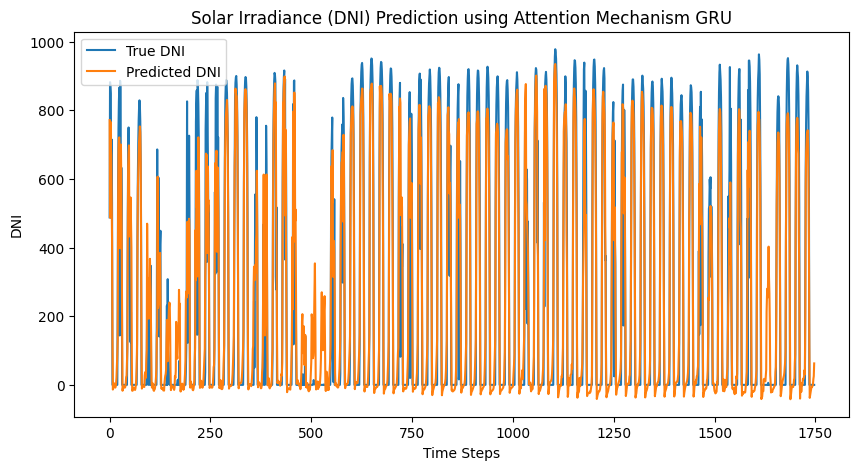

In [59]:
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_true_attn, label='True DNI')
plt.plot(y_pred_attn, label='Predicted DNI')
plt.title('Solar Irradiance (DNI) Prediction using Attention Mechanism GRU')
plt.xlabel('Time Steps')
plt.ylabel('DNI')
plt.legend()
plt.show()

TRANSFORMER

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math

# Positional Encoding (same as before)
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

# Transformer Encoder Model
class TransformerRegressor(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.input_proj(x)  # (batch, seq_len, d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        out = x[:, -1, :]  # Use output from last time step
        return self.fc_out(out)
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerRegressor(input_size=X_train.shape[2]).to(device)

# Dataset and Dataloader
batch_size = 32
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 20
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

# Evaluation
model.eval()
y_pred_scaled = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred_scaled.append(outputs.cpu().numpy())

y_pred_scaled = np.concatenate(y_pred_scaled)
y_pred_trans = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true_trans = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

Epoch 1/20, Loss: 0.0297
Epoch 2/20, Loss: 0.0182
Epoch 3/20, Loss: 0.0168
Epoch 4/20, Loss: 0.0163
Epoch 5/20, Loss: 0.0162
Epoch 6/20, Loss: 0.0154
Epoch 7/20, Loss: 0.0151
Epoch 8/20, Loss: 0.0148
Epoch 9/20, Loss: 0.0150
Epoch 10/20, Loss: 0.0147
Epoch 11/20, Loss: 0.0143
Epoch 12/20, Loss: 0.0145
Epoch 13/20, Loss: 0.0142
Epoch 14/20, Loss: 0.0141
Epoch 15/20, Loss: 0.0139
Epoch 16/20, Loss: 0.0142
Epoch 17/20, Loss: 0.0132
Epoch 18/20, Loss: 0.0134
Epoch 19/20, Loss: 0.0136
Epoch 20/20, Loss: 0.0131


TransformerRegressor - MSE: 16360.8925
MAE: 56.5405
R² Score: 0.8693
RMSE: 127.9097


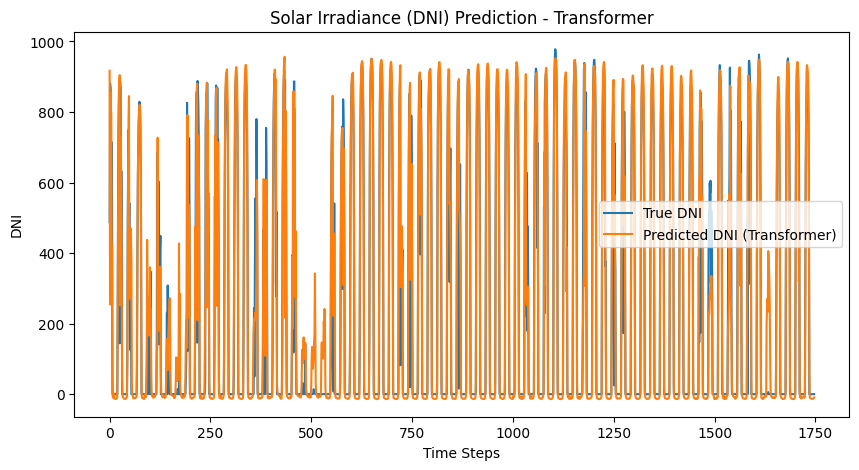

In [61]:
# Evaluate TransformerRegressor
model.eval()
y_pred_scaled = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_pred_scaled.append(outputs.cpu().numpy())

# Concatenate and inverse scale
y_pred_scaled = np.concatenate(y_pred_scaled)
y_pred_transformer = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true_transformer = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluation Metrics
mse_tr = mean_squared_error(y_true_transformer, y_pred_transformer)
mae_tr = mean_absolute_error(y_true_transformer, y_pred_transformer)
r2_tr = r2_score(y_true_transformer, y_pred_transformer)
rmse_tr = np.sqrt(mse_tr)

print(f"TransformerRegressor - MSE: {mse_tr:.4f}")
print(f"MAE: {mae_tr:.4f}")
print(f"R² Score: {r2_tr:.4f}")
print(f"RMSE: {rmse_tr:.4f}")
# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_true_transformer, label='True DNI')
plt.plot(y_pred_transformer, label='Predicted DNI (Transformer)')
plt.title('Solar Irradiance (DNI) Prediction - Transformer')
plt.xlabel('Time Steps')
plt.ylabel('DNI')
plt.legend()
plt.show()


Transformer + Attention Model (Self-Attention Layer After Transformer)

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import math

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)].to(x.device)

# Attention Pooling Layer
class AttentionPooling(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.attn = nn.Linear(d_model, 1)

    def forward(self, x):
        attn_weights = torch.softmax(self.attn(x), dim=1)
        context = (x * attn_weights).sum(dim=1)
        return context

# Transformer Regressor with Attention Pooling
class TransformerAttentionRegressor(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2, dim_feedforward=128, dropout=0.1):
        super().__init__()
        self.input_proj = nn.Linear(input_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.attn_pool = AttentionPooling(d_model)
        self.fc = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)
        )
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.norm(x)
        x = self.attn_pool(x)
        return self.fc(x)

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerAttentionRegressor(input_size=X_train.shape[2]).to(device)

batch_size = 64
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                              torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                             torch.tensor(y_test, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
num_epochs = 20
best_val_loss = float('inf')

# Training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs).squeeze(-1)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs).squeeze(-1)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    scheduler.step(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_transformer_attention_regressor.pt')
        print("Saved best model.")



Epoch 1/20, Train Loss: 0.0661, Val Loss: 0.0286
Saved best model.
Epoch 2/20, Train Loss: 0.0258, Val Loss: 0.0318
Epoch 3/20, Train Loss: 0.0211, Val Loss: 0.0226
Saved best model.
Epoch 4/20, Train Loss: 0.0189, Val Loss: 0.0196
Saved best model.
Epoch 5/20, Train Loss: 0.0187, Val Loss: 0.0181
Saved best model.
Epoch 6/20, Train Loss: 0.0178, Val Loss: 0.0177
Saved best model.
Epoch 7/20, Train Loss: 0.0165, Val Loss: 0.0175
Saved best model.
Epoch 8/20, Train Loss: 0.0161, Val Loss: 0.0185
Epoch 9/20, Train Loss: 0.0161, Val Loss: 0.0169
Saved best model.
Epoch 10/20, Train Loss: 0.0160, Val Loss: 0.0182
Epoch 11/20, Train Loss: 0.0158, Val Loss: 0.0244
Epoch 12/20, Train Loss: 0.0153, Val Loss: 0.0236
Epoch 13/20, Train Loss: 0.0153, Val Loss: 0.0196
Epoch 14/20, Train Loss: 0.0143, Val Loss: 0.0188
Epoch 15/20, Train Loss: 0.0143, Val Loss: 0.0161
Saved best model.
Epoch 16/20, Train Loss: 0.0136, Val Loss: 0.0189
Epoch 17/20, Train Loss: 0.0142, Val Loss: 0.0175
Epoch 18/20, Tr


📊 Best Model Evaluation:
Test MSE: 15101.7852
Test MAE: 51.4490
Test RMSE: 122.8893
Test R² Score: 0.8793


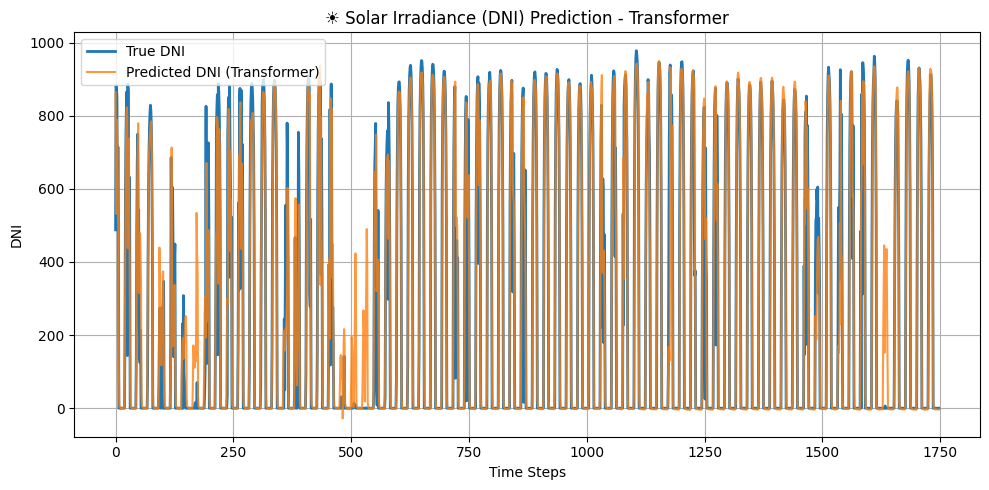

In [67]:
# Evaluation
best_model = TransformerAttentionRegressor(input_size=X_test.shape[2]).to(device)
best_model.load_state_dict(torch.load('best_transformer_attention_regressor.pt'))
best_model.eval()

# Predict
y_pred_scaled = []
with torch.no_grad():
    for inputs, _ in test_loader:
        inputs = inputs.to(device)
        outputs = best_model(inputs)
        y_pred_scaled.append(outputs.cpu().numpy())

y_pred_scaled = np.concatenate(y_pred_scaled)

# Inverse scaling
y_pred_trans = scaler_y.inverse_transform(y_pred_scaled).flatten()
y_true_trans = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Metrics
mse = mean_squared_error(y_true_trans, y_pred_trans)
r2 = r2_score(y_true_trans, y_pred_trans)
mae = mean_absolute_error(y_true_trans, y_pred_trans)
rmse = np.sqrt(mse)

print(f"\n📊 Best Model Evaluation:")
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test R² Score: {r2:.4f}")

# Plot
plt.figure(figsize=(10, 5))
plt.plot(y_true_trans, label='True DNI', linewidth=2)
plt.plot(y_pred_trans, label='Predicted DNI (Transformer)', alpha=0.8)
plt.title('☀️ Solar Irradiance (DNI) Prediction - Transformer')
plt.xlabel('Time Steps')
plt.ylabel('DNI')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()